## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
import pandas as pd

## Preparar os dados

In [2]:
data = np.loadtxt("../data/spiral_d.csv", delimiter=",")
X = data[:, :2].T   # 2 x N
y = data[:, 2]      # N
y = np.where(y==1, 1, -1)

print(data.shape)

(1400, 3)


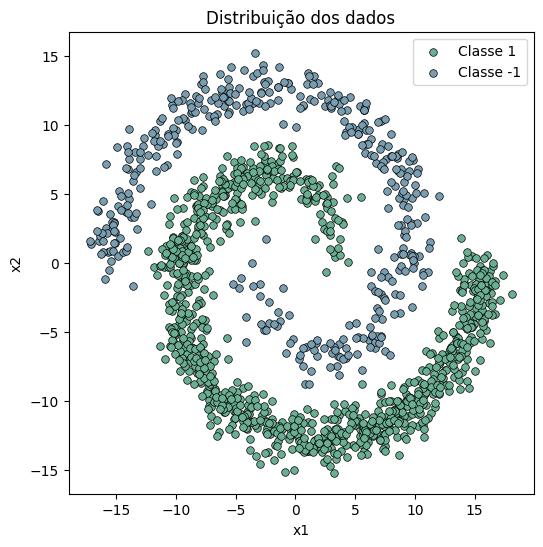

In [3]:
plt.figure(figsize=(6,6))
plt.scatter(X[0, y==1], X[1, y==1],
            marker='o', color='#6BAF92', edgecolor='black', linewidth=0.5, s=30, label='Classe 1')
plt.scatter(X[0, y==-1], X[1, y==-1],
            marker='o', color='#7A9EB1', edgecolor='black', linewidth=0.5, s=30, label='Classe -1')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Distribuição dos dados")
plt.legend()
plt.show()

#### Separando dados

In [4]:
# Particionamento 80% treino, 20% teste
N = X.shape[1]
indices = np.arange(N)
np.random.shuffle(indices)
N_train = int(0.8*N)
train_idx = indices[:N_train]
test_idx  = indices[N_train:]

X_train = X[:, train_idx]
y_train = y[train_idx]

X_test  = X[:, test_idx]
y_test  = y[test_idx]

## Classes

### Funções auxiliares

In [5]:
def show_classification_results(model_name, cm, acc, sensitivity, specificity, precision, f1):
    print(f"{model_name} - Resultados da Classificação:")
    print(f"\nAcurácia: {acc:.3f}")
    print(f"Sensibilidade: {sensitivity:.3f}")
    print(f"Especificidade: {specificity:.3f}")
    print(f"Precisão: {precision:.3f}")
    print(f"F1 Score: {f1:.3f}\n")
    
    # Heatmap da matriz de confusão
    plt.figure(figsize=(5,4))
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Positivo (1)", "Negativo (-1)"],
                yticklabels=["Positivo (1)", "Negativo (-1)"])
    
    plt.xlabel("Classe Prevista")
    plt.ylabel("Classe Verdadeira")
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.show()

def confusion_matrix_manual(y_true, y_pred):
    """
    Cria a matriz de confusão:
    TP (1, 1)  FP (1, -1)
    TN (-1, 1) FN (-1, -1)
    """

    TP_std = np.sum((y_true==1) & (y_pred==1))  # Real=1, Prev=1
    FN_std = np.sum((y_true==1) & (y_pred==-1))   # Real=1, Prev=-1
    FP_std = np.sum((y_true==-1) & (y_pred==1))   # Real=-1, Prev=1
    TN_std = np.sum((y_true==-1) & (y_pred==-1))   # Real=-1, Prev=-1
    
    TP = TP_std  # (1, 1)
    FP = FN_std  # (1, -1)
    TN = FP_std  # (-1, 1)
    FN = TN_std  # (-1, -1)

    # Retorna a matriz na estrutura [[TP, FP], [TN, FN]]
    return np.array([[TP, FP],
                     [TN, FN]])

# Métricas
def metrics(cm):
    """
    Calcula métricas a partir da matriz:
    cm = [[TP_usr, FP_usr],
          [TN_usr, FN_usr]]
    """
    TP_usr, FP_usr = cm[0]
    TN_usr, FN_usr = cm[1]
    
    TP = TP_usr
    FN = FP_usr
    FP = TN_usr
    TN = FN_usr

    Total = TP + TN + FP + FN
    acc = (TP+TN) / Total if Total != 0 else 0
    sens = TP/(TP+FN) if (TP+FN)!=0 else 0
    spec = TN/(TN+FP) if (TN+FP)!=0 else 0
    prec = TP/(TP+FP) if (TP+FP)!=0 else 0
    f1 = 2*prec*sens/(prec+sens) if (prec+sens)!=0 else 0
    
    return acc, sens, spec, prec, f1

In [6]:
def monte_carlo_split(X, Y, train_ratio=0.8):
    N = X.shape[1]
    idx = np.random.permutation(N)
    train_size = int(train_ratio * N)
    train_idx = idx[:train_size]
    test_idx = idx[train_size:]
    return X[:, train_idx], Y[:, train_idx], X[:, test_idx], Y[:, test_idx]

def monte_carlo_split_vector(X, y, train_ratio=0.8):
    N = X.shape[1]
    idx = np.random.permutation(N)
    train_size = int(train_ratio * N)
    train_idx = idx[:train_size]
    test_idx = idx[train_size:]
    return X[:, train_idx], y[train_idx], X[:, test_idx], y[test_idx]


In [7]:
def accuracy(y_true, y_pred):
    pred_class = np.argmax(y_pred, axis=0)
    true_class = np.argmax(y_true, axis=0)
    return np.mean(pred_class == true_class)

In [8]:
class Perceptron:
    def __init__(self, X_train, y_train, learning_rate=1e-3, plot=True, max_epochs=1000):
        self.p, self.N = X_train.shape
        self.X_train = np.vstack((
            -np.ones((1, self.N)), X_train
        ))
        self.d = y_train
        self.lr = learning_rate
        self.w = np.random.random_sample((self.p+1,1)) - 0.5
        self.plot = plot
        self.max_epochs = max_epochs
        self.x1 = np.linspace(-2, 10)
        
        if plot:
            self.fig = plt.figure(1)
            self.ax = self.fig.add_subplot()
            self.ax.scatter(self.X_train[1, self.d[:]==1],
                            self.X_train[2, self.d[:]==1], marker='s', s=120)
            self.ax.scatter(self.X_train[1, self.d[:]==-1],
                            self.X_train[2, self.d[:]==-1], marker='o', s=120)
            self.ax.set_xlim(-1, 7)
            self.ax.set_ylim(-1, 7)
            self.draw_line()
        
    def draw_line(self, c='k', alpha=1, lw=2):
        x2 = -self.w[1,0]/self.w[2,0]*self.x1 + self.w[0,0]/self.w[2,0]
        x2 = np.nan_to_num(x2)
        if self.plot:
            plt.plot(self.x1, x2, c=c, alpha=alpha, lw=lw)
        
    def activation_function(self, u):
        return 1 if u >= 0 else -1
    
    def fit(self):
        epochs = 0
        error = True
        while error and epochs < self.max_epochs:
            error = False
            for k in range(self.N):
                x_k = self.X_train[:, k].reshape(self.p+1, 1)
                u_k = (self.w.T @ x_k)[0,0]
                y_k = self.activation_function(u_k)
                d_k = self.d[k]
                e_k = d_k - y_k
                if e_k != 0:
                    error = True
                self.w = self.w + self.lr * e_k * x_k
            
            if self.plot:
                plt.pause(.4)
                self.draw_line(c='r', alpha=.5)
            epochs += 1
        
        if self.plot:
            plt.pause(.4)
            self.draw_line(c='g', alpha=1, lw=4)
            plt.show()

        # plt.figure(figsize=(6,5))
        # plt.scatter(self.X_train[1, self.d[:]==1], self.X_train[2, self.d[:]==1], marker='s', s=120, label='Classe 1')
        # plt.scatter(self.X_train[1, self.d[:]==-1], self.X_train[2, self.d[:]==-1], marker='o', s=120, label='Classe -1')
        # min_x1 = self.X_train[1, :].min() - 1  # Adiciona uma margem
        # max_x1 = self.X_train[1, :].max() + 1  # Adiciona uma margem
        # x1 = np.linspace(min_x1, max_x1)
        # x2 = -self.w[1,0]/self.w[2,0]*x1 + self.w[0,0]/self.w[2,0]
        # x2 = np.nan_to_num(x2)
        # plt.plot(x1, x2, c='g', lw=4, label='Linha de decisão final')
        # plt.xlabel("x1")
        # plt.ylabel("x2")
        # plt.title(f"Perceptron - Última época ({epochs})")
        # plt.legend()
        # plt.show()
        if epochs == self.max_epochs:
            misclassified = [k for k in range(self.N) 
            if self.activation_function((self.w.T @ self.X_train[:, k].reshape(self.p+1,1))[0,0]) != self.d[k]]
            # print(f'Treinamento interrompido após {epochs} épocas (não convergiu completamente).')
            # print("Índices dos exemplos incorretos:", misclassified)
            # print("Pesos finais:", self.w.ravel())
        else:
            print(f'Treinamento concluído em {epochs} épocas.')

    def predict(self, X):
        N = X.shape[1]
        y_pred = np.zeros(N)
        for i in range(N):
            x_i = np.vstack((-np.ones((1,1)), X[:,i].reshape(-1,1)))
            y_pred[i] = self.activation_function((self.w.T @ x_i)[0,0])
        return y_pred

In [9]:
class ADALINE:
    def __init__(self, lr=1e-3, max_epochs=500, print_every=50, random_state=0):
        self.lr = lr
        self.max_epochs = max_epochs
        self.print_every = print_every
        self.rs = np.random.default_rng(random_state)
        self.w = None
        self.eqm_hist = []
        self.acc_hist = []
        self.val_acc_hist = []

    def _augment(self, X):
        # adiciona linha de bias (-1)
        return np.vstack([-np.ones((1, X.shape[1]), np.float32), X])

    def fit(self, X, y, X_val=None, y_val=None):
        Xp = X.astype(np.float32)
        d = y.astype(np.float32)
        Xb = self._augment(Xp)
        p1, N = Xb.shape

        # pesos iniciais
        self.w = (self.rs.random((p1, 1)).astype(np.float32) - 0.5)
        self.eqm_hist, self.acc_hist, self.val_acc_hist = [], [], []
        order = np.arange(N)

        for ep in range(1, self.max_epochs + 1):
            self.rs.shuffle(order)
            for k in order:
                x = Xb[:, [k]]
                u = float(self.w.T @ x)
                e = d[k] - u
                self.w = self.w + self.lr * x * e

            # cálculo de erro e acurácia
            U = (self.w.T @ Xb).ravel()
            E = d - U
            eqm = float(np.sum(E * E) / (2.0 * N))
            yhat = np.where(U >= 0, 1, -1)
            acc = float(np.mean(yhat == d))

            self.eqm_hist.append(eqm)
            self.acc_hist.append(acc)

            # validação
            if X_val is not None and y_val is not None:
                y_val_hat = self.predict(X_val)
                acc_val = float(np.mean(y_val_hat == y_val))
                self.val_acc_hist.append(acc_val)

            if (ep % self.print_every) == 0:
                if self.val_acc_hist:
                    print(f'Época {ep:3d} | EQM={eqm:.6f} | acc_treino={acc:.4f} | acc_teste={self.val_acc_hist[-1]:.4f}')
                else:
                    print(f'Época {ep:3d} | EQM={eqm:.6f} | acc_treino={acc:.4f}')
        return self

    def decision_function(self, X):
        # também sem transpor
        Xp = X.astype(np.float32)
        Xb = self._augment(Xp)
        return (self.w.T @ Xb).ravel()

    def predict(self, X):
        return np.where(self.decision_function(X) >= 0, 1, -1)


In [10]:
class MultilayerPerceptron:
    def __init__(self,X_train:np.ndarray, Y_train:np.ndarray, topology:list, learning_rate = 1e-3, max_epoch=10000, tol = 1e-12):
        '''
        X_train (p x N)
        Y_train (C x N) ou (1 x N) se classificação binária
        '''
        self.p , self.N = X_train.shape
        self.m = Y_train.shape[0]
        
        self.X_train = np.vstack((
            -np.ones((1,self.N)),X_train
        ))
        self.tol = tol
        self.lr = learning_rate
        self.d = Y_train
        topology.append(self.m)
        self.W = [None]*len(topology)
        Z = 0
        for i in range(len(self.W)):
            if i == 0:
                W = np.random.random_sample((topology[i],self.p+1))-.5
            else:
                W = np.random.random_sample((topology[i],topology[i-1]+1))-.5
            self.W[i] = W
            Z += W.size
        print(f"Rede MLP com {Z} parâmetros")
        self.max_epoch = max_epoch
        self.y = [None]*len(topology)
        self.u = [None]*len(topology)
        self.delta = [None]*len(topology)
        
    def g(self, u):
        return (1-np.exp(-u))/(1+np.exp(-u))
    
    def g_d(self, u):
        y = self.g(u)
        return .5*(1-y**2)
    
    def backward(self, e,x):
        for i in range(len(self.W)-1,-1,-1):
            if i == len(self.W)-1:
                self.delta[i] = self.g_d(self.u[i]) * e
                yb = np.vstack((
                    -np.ones((1,1)),
                    self.y[i-1]
                ))
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@yb.T)
            elif i == 0:
                Wnbt = (self.W[i+1][:,1:]).T
                self.delta[i] = self.g_d(self.u[i]) * (Wnbt@self.delta[i+1])
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@x.T)
                
            else:
                Wnbt = (self.W[i+1][:,1:]).T
                self.delta[i] = self.g_d(self.u[i]) * (Wnbt@self.delta[i+1])
                yb = np.vstack((
                    -np.ones((1,1)),
                    self.y[i-1]
                ))
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@yb.T)
            
    
    def forward(self, x):
        
        for i,W in enumerate(self.W):
            if i == 0:
                self.u[i] = W@x
            else:
                yb = np.vstack((
                    -np.ones((1,1)), self.y[i-1]
                ))
                self.u[i] = W@yb                
            self.y[i] = self.g(self.u[i])
         
        
        
    def EQM(self):
        s = 0
        for k in range(self.N):
            x_k = self.X_train[:,k].reshape(self.p+1,1)
            self.forward(x_k)
            y = self.y[-1]
            d = self.d[:,k].reshape(self.m,1)
            e = d - y
            s += np.sum(e**2)
        return s/(2*self.N)
        
    def fit(self):
        epoch = 0
        EQM1 = 1
        self.history = []
        
        while epoch < self.max_epoch and EQM1>self.tol:
            t1 = time()
            for k in range(self.N):
                x_k = self.X_train[:,k].reshape(self.p+1,1)
                #Forward
                self.forward(x_k)
                y = self.y[-1]
                d = self.d[:,k].reshape(self.m,1)
                e = d - y
                #Backward
                self.backward(e,x_k)
            t2 = time()
            EQM1 = self.EQM()
            self.history.append(EQM1)
            epoch+=1
            print(f"Tempo: {t2-t1:.5f}s  Época: {epoch}, EQM: {EQM1:.15f}")

    def predict(self, X):
        """
        Faz a predição para novos dados X (p x N_test)
        Retorna uma matriz de saída (m x N_test)
        """
        N_test = X.shape[1]

        X_bias = np.vstack((-np.ones((1, N_test)), X))
        
        Y_pred = np.zeros((self.m, N_test))
        
        for k in range(N_test):
            x_k = X_bias[:, k].reshape(self.p+1, 1)
            self.forward(x_k)
            Y_pred[:, k] = self.y[-1][:, 0]
        
        return Y_pred


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# --- Configuração ---
# ==========================================
R_simulations = 500
acc_list, sens_list, spec_list, prec_list, f1_list = [], [], [], [], []
cms, splits = [], []
eqm_histories, acc_histories, val_acc_histories = [], [], []

# ==========================================
# --- Simulações Monte Carlo ---
# ==========================================
for r in range(R_simulations):
    # Split dos dados
    X_train, y_train, X_test, y_test = monte_carlo_split_vector(X, y)

    # Treinamento com validação
    model = ADALINE(lr=0.00001, max_epochs=200, print_every=250)
    model.fit(X_train, y_train, X_val=X_test, y_val=y_test)

    # Teste final
    y_pred = model.predict(X_test)

    # Métricas
    cm = confusion_matrix_manual(y_test, y_pred)
    acc, sens, spec, prec, f1 = metrics(cm)

    # Armazenamento
    acc_list.append(acc)
    sens_list.append(sens)
    spec_list.append(spec)
    prec_list.append(prec)
    f1_list.append(f1)
    cms.append(cm)
    splits.append((X_train, y_train, X_test, y_test, model))

    # Histórico de aprendizado
    eqm_histories.append(model.eqm_hist)
    acc_histories.append(model.acc_hist)
    val_acc_histories.append(model.val_acc_hist)

    print(f"Rodada {r+1}/{R_simulations} — Acurácia: {acc:.3f}")

C:\Users\User\AppData\Local\Temp\ipykernel_8556\1581314601.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(self.w.T @ x)


Rodada 1/500 — Acurácia: 0.746
Rodada 2/500 — Acurácia: 0.768
Rodada 3/500 — Acurácia: 0.761
Rodada 4/500 — Acurácia: 0.750
Rodada 5/500 — Acurácia: 0.746
Rodada 6/500 — Acurácia: 0.718
Rodada 7/500 — Acurácia: 0.757
Rodada 8/500 — Acurácia: 0.754
Rodada 9/500 — Acurácia: 0.754
Rodada 10/500 — Acurácia: 0.750
Rodada 11/500 — Acurácia: 0.771
Rodada 12/500 — Acurácia: 0.761
Rodada 13/500 — Acurácia: 0.768



==== Resultados Médios ====
Acurácia média: 0.7635 | Desvio: 0.0241

Melhor rodada: 88 | Acurácia = 0.8429
Pior rodada:   147 | Acurácia = 0.6857
ADALINE - Melhor rodada - Resultados da Classificação:

Acurácia: 0.843
Sensibilidade: 0.923
Especificidade: 0.655
Precisão: 0.862
F1 Score: 0.892



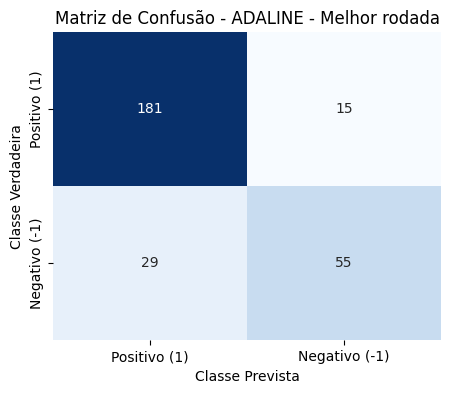

ADALINE - Pior rodada - Resultados da Classificação:

Acurácia: 0.686
Sensibilidade: 0.764
Especificidade: 0.481
Precisão: 0.795
F1 Score: 0.779



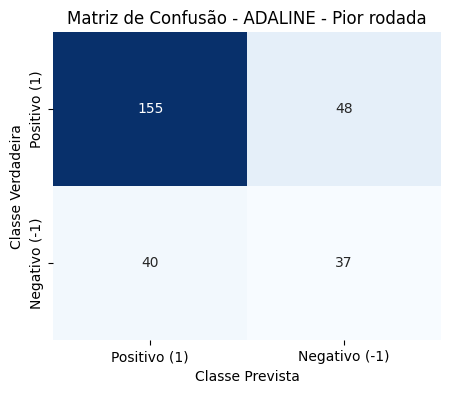

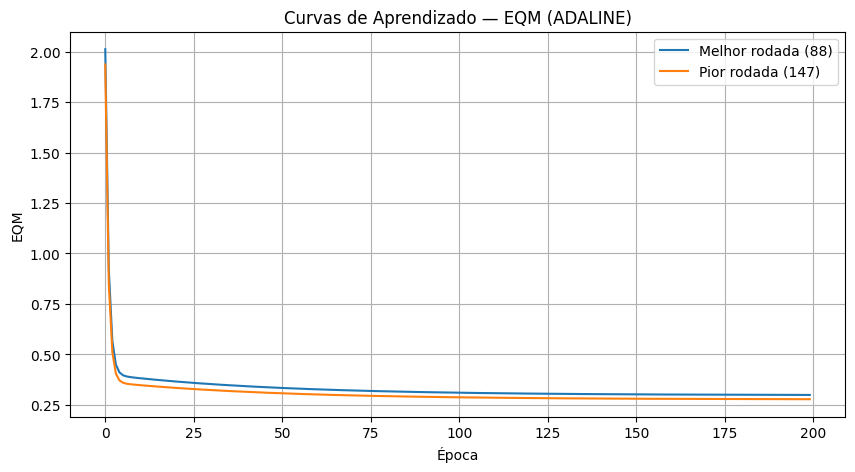

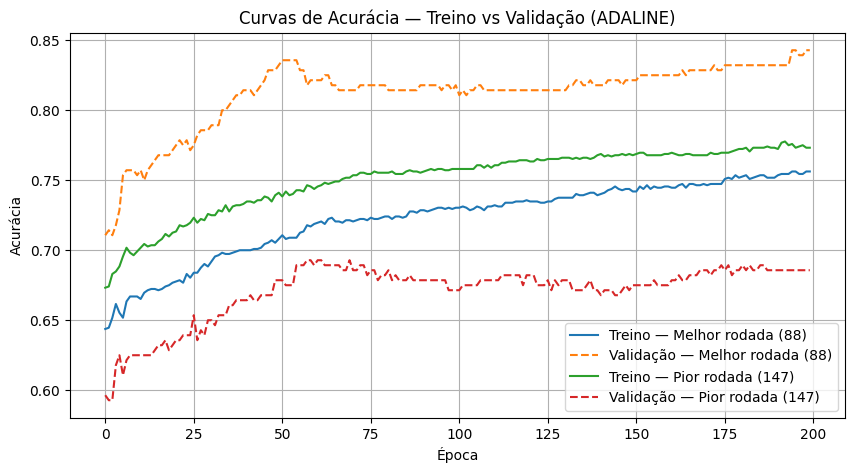


===== RESUMO (R=500) — ADALINE =====
Média : [0.7635 0.8414 0.57   0.8299 0.8353]
DP    : [0.0241 0.0254 0.0512 0.0247 0.0184]
Maiores: [0.8429 0.9235 0.7625 0.9031 0.8916]
Menores: [0.6857 0.7635 0.4419 0.7451 0.7789]


,Média,Desvio-Padrão,Maior,Menor
Acurácia,0.7635,0.0241,0.8429,0.6857
Sensibilidade,0.8414,0.0254,0.9235,0.7635
Especificidade,0.5700,0.0512,0.7625,0.4419
Precisão,0.8299,0.0247,0.9031,0.7451
F1-score,0.8353,0.0184,0.8916,0.7789


In [ ]:
# ==========================================
# --- Resultados gerais ---
# ==========================================
acc_arr = np.array(acc_list)

print("\n==== Resultados Médios ====")
print(f"Acurácia média: {acc_arr.mean():.4f} | Desvio: {acc_arr.std():.4f}")

# Melhores e piores rodadas
idx_best, idx_worst = np.argmax(acc_arr), np.argmin(acc_arr)
print(f"\nMelhor rodada: {idx_best+1} | Acurácia = {acc_arr[idx_best]:.4f}")
print(f"Pior rodada:   {idx_worst+1} | Acurácia = {acc_arr[idx_worst]:.4f}")

# Exibir matrizes de confusão
show_classification_results(
    "ADALINE - Melhor rodada", cms[idx_best],
    acc_list[idx_best], sens_list[idx_best], spec_list[idx_best],
    prec_list[idx_best], f1_list[idx_best]
)

show_classification_results(
    "ADALINE - Pior rodada", cms[idx_worst],
    acc_list[idx_worst], sens_list[idx_worst], spec_list[idx_worst],
    prec_list[idx_worst], f1_list[idx_worst]
)

# ==========================================
# --- Curvas de aprendizado ---
# ==========================================
plt.figure(figsize=(10,5))
plt.plot(eqm_histories[idx_best], label=f"Melhor rodada ({idx_best+1})")
plt.plot(eqm_histories[idx_worst], label=f"Pior rodada ({idx_worst+1})")
plt.xlabel("Época")
plt.ylabel("EQM")
plt.title("Curvas de Aprendizado — EQM (ADALINE)")
plt.legend()
plt.grid(True)
plt.show()

# Curvas de acurácia treino/validação
plt.figure(figsize=(10,5))
plt.plot(acc_histories[idx_best], label=f"Treino — Melhor rodada ({idx_best+1})")
if val_acc_histories[idx_best]:
    plt.plot(val_acc_histories[idx_best], '--', label=f"Validação — Melhor rodada ({idx_best+1})")
plt.plot(acc_histories[idx_worst], label=f"Treino — Pior rodada ({idx_worst+1})")
if val_acc_histories[idx_worst]:
    plt.plot(val_acc_histories[idx_worst], '--', label=f"Validação — Pior rodada ({idx_worst+1})")

plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Curvas de Acurácia — Treino vs Validação (ADALINE)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================
# --- Resumo estatístico ---
# ==========================================
rows = np.array(list(zip(acc_list, sens_list, spec_list, prec_list, f1_list)), dtype=np.float32)
m, s, mx, mn = rows.mean(0), rows.std(0, ddof=1), rows.max(0), rows.min(0)
labels = ['Acurácia', 'Sensibilidade', 'Especificidade', 'Precisão', 'F1-score']

df_resumo = pd.DataFrame({
    'Média': m,
    'Desvio-Padrão': s,
    'Maior': mx,
    'Menor': mn
}, index=labels).round(4)

# Impressão final
print(f'\n===== RESUMO (R={R_simulations}) — ADALINE =====')
print('Média :', np.round(m, 4))
print('DP    :', np.round(s, 4))
print('Maiores:', np.round(mx, 4))
print('Menores:', np.round(mn, 4))

display(df_resumo)


In [ ]:
R_simulations = 500
acc_list, sens_list, spec_list, prec_list, f1_list = [], [], [], [], []
cms = []
splits = []

for r in range(R_simulations):
    # --- Monte Carlo split ---
    X_train, y_train, X_test, y_test = monte_carlo_split_vector(X, y)

    # Garante formato (N,) para o Perceptron
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    # --- Treinamento ---
    perceptron = Perceptron(
        X_train=X_train,
        y_train=y_train,
        learning_rate=0.01,
        plot=False,
        max_epochs=500
    )
    perceptron.fit()

    # --- Teste ---
    y_pred = perceptron.predict(X_test)

    # --- Métricas ---
    cm = confusion_matrix_manual(y_test, y_pred)
    acc, sens, spec, prec, f1 = metrics(cm)

    # --- Armazenamento ---
    acc_list.append(acc)
    sens_list.append(sens)
    spec_list.append(spec)
    prec_list.append(prec)
    f1_list.append(f1)
    cms.append(cm)
    splits.append((X_train, y_train, X_test, y_test, perceptron))
    
    print(f"Rodada {r+1}/{R_simulations} — Acurácia: {acc:.3f}")

Rodada 1/500 — Acurácia: 0.696
Rodada 2/500 — Acurácia: 0.736
Rodada 3/500 — Acurácia: 0.693
Rodada 4/500 — Acurácia: 0.743
Rodada 5/500 — Acurácia: 0.686
Rodada 6/500 — Acurácia: 0.668
Rodada 7/500 — Acurácia: 0.554
Rodada 8/500 — Acurácia: 0.846
Rodada 9/500 — Acurácia: 0.654
Rodada 10/500 — Acurácia: 0.664
Rodada 11/500 — Acurácia: 0.736
Rodada 12/500 — Acurácia: 0.614
Rodada 13/500 — Acurácia: 0.696
Rodada 14/500 — Acurácia: 0.596
Rodada 15/500 — Acurácia: 0.786
Rodada 16/500 — Acurácia: 0.732
Rodada 17/500 — Acurácia: 0.746
Rodada 18/500 — Acurácia: 0.654
Rodada 19/500 — Acurácia: 0.636
Rodada 20/500 — Acurácia: 0.807
Rodada 21/500 — Acurácia: 0.564
Rodada 22/500 — Acurácia: 0.764
Rodada 23/500 — Acurácia: 0.739
Rodada 24/500 — Acurácia: 0.736
Rodada 25/500 — Acurácia: 0.757
Rodada 26/500 — Acurácia: 0.732
Rodada 27/500 — Acurácia: 0.525
Rodada 28/500 — Acurácia: 0.771
Rodada 29/500 — Acurácia: 0.721
Rodada 30/500 — Acurácia: 0.775
Rodada 31/500 — Acurácia: 0.825
Rodada 32/500 — A

In [ ]:
# --- Estatísticas finais ---
rows = np.array([acc_list, sens_list, spec_list, prec_list, f1_list], dtype=np.float32).T
m, s, mx, mn = rows.mean(0), rows.std(0, ddof=1), rows.max(0), rows.min(0)
labels = ['Acurácia', 'Sensibilidade', 'Especificidade', 'Precisão', 'F1-score']

df_resumo = pd.DataFrame({
    'Média': m,
    'Desvio-Padrão': s,
    'Maior': mx,
    'Menor': mn
}, index=labels).round(4)

print("\n===== RESUMO FINAL (R=500) =====")
print("Média :", np.round(m, 4))
print("Desvio Padrão:", np.round(s, 4))
print("Maiores:", np.round(mx, 4))
print("Menores:", np.round(mn, 4))

display(df_resumo)

# --- Seleção dos casos extremos ---
acc_arr = np.array(acc_list)
idx_best = np.argmax(acc_arr)
idx_worst = np.argmin(acc_arr)

print("\nMelhor rodada:", idx_best+1, " | Acurácia =", acc_arr[idx_best])
print("Pior rodada:  ", idx_worst+1, " | Acurácia =", acc_arr[idx_worst])

# --- Exibir matrizes de confusão dos extremos ---
show_classification_results("Perceptron - Melhor rodada", cms[idx_best],
                            acc_list[idx_best], sens_list[idx_best], spec_list[idx_best],
                            prec_list[idx_best], f1_list[idx_best])

show_classification_results("Perceptron - Pior rodada", cms[idx_worst],
                            acc_list[idx_worst], sens_list[idx_worst], spec_list[idx_worst],
                            prec_list[idx_worst], f1_list[idx_worst])


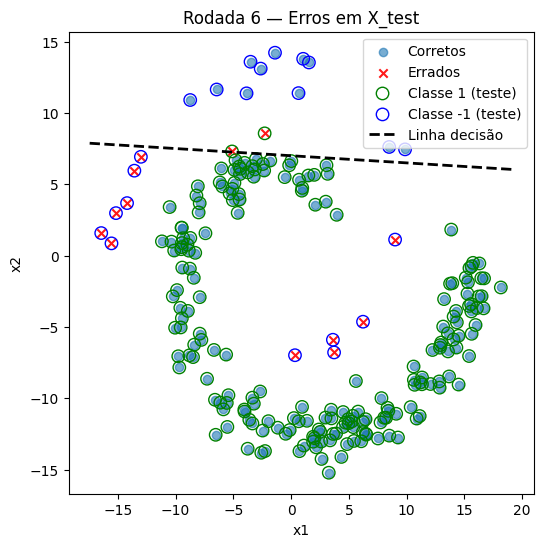

In [ ]:
idx = idx_best
X_tr, y_tr, X_te, y_te, model = splits[idx]

# Plot de teste com pontos corretos e incorretos
y_pred = model.predict(X_te)
correct = (y_pred == y_te)
wrong = ~correct

plt.figure(figsize=(6,6))
plt.scatter(X_te[0, correct], X_te[1, correct], marker='o', label='Corretos', alpha=0.6)
plt.scatter(X_te[0, wrong], X_te[1, wrong], marker='x', color='r', label='Errados', alpha=0.9)
# destaca classes separadamente
plt.scatter(X_te[0, y_te==1], X_te[1, y_te==1], facecolors='none', edgecolors='g', s=80, label='Classe 1 (teste)')
plt.scatter(X_te[0, y_te==-1], X_te[1, y_te==-1], facecolors='none', edgecolors='b', s=80, label='Classe -1 (teste)')

# desenha linha de decisão do perceptron
w = model.w.ravel()
x1 = np.linspace(X_te[0,:].min()-1, X_te[0,:].max()+1, 200)
x2 = -w[1]/w[2] * x1 + w[0]/w[2]
plt.plot(x1, x2, 'k--', linewidth=2, label='Linha decisão')

plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title(f'Rodada {idx+1} — Erros em X_test (Melhor Rodada)')
plt.show()

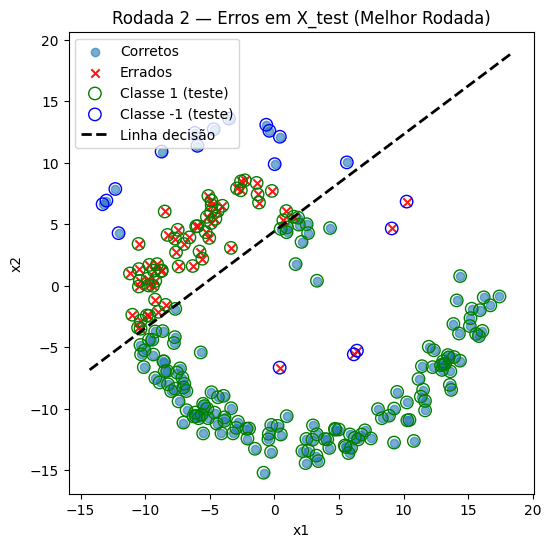

In [ ]:
idx = idx_worst
X_tr, y_tr, X_te, y_te, model = splits[idx]

# Plot de teste com pontos corretos e incorretos
y_pred = model.predict(X_te)
correct = (y_pred == y_te)
wrong = ~correct

plt.figure(figsize=(6,6))
plt.scatter(X_te[0, correct], X_te[1, correct], marker='o', label='Corretos', alpha=0.6)
plt.scatter(X_te[0, wrong], X_te[1, wrong], marker='x', color='r', label='Errados', alpha=0.9)
# destaca classes separadamente
plt.scatter(X_te[0, y_te==1], X_te[1, y_te==1], facecolors='none', edgecolors='g', s=80, label='Classe 1 (teste)')
plt.scatter(X_te[0, y_te==-1], X_te[1, y_te==-1], facecolors='none', edgecolors='b', s=80, label='Classe -1 (teste)')

# desenha linha de decisão do perceptron
w = model.w.ravel()
x1 = np.linspace(X_te[0,:].min()-1, X_te[0,:].max()+1, 200)
x2 = -w[1]/w[2] * x1 + w[0]/w[2]
plt.plot(x1, x2, 'k--', linewidth=2, label='Linha decisão')

plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title(f'Rodada {idx+1} — Erros em X_test (Pior Rodada)')
plt.show()

In [ ]:
# Preparar labels para MLP (1 x N)
Y_train_mlp = y_train.reshape(1, -1)
Y_test_mlp  = y_test.reshape(1, -1)

Rede MLP com 266 parâmetros
Tempo: 0.29794s  Época: 1, EQM: 0.429444936681386
Tempo: 0.17721s  Época: 2, EQM: 0.423712884929400
Tempo: 0.26506s  Época: 3, EQM: 0.418773779830021
Tempo: 0.17454s  Época: 4, EQM: 0.414427469665173
Tempo: 0.22288s  Época: 5, EQM: 0.410522300013986
Tempo: 0.19026s  Época: 6, EQM: 0.406942639031433
Tempo: 0.17901s  Época: 7, EQM: 0.403599822904237
Tempo: 0.18979s  Época: 8, EQM: 0.400425584346446
Tempo: 0.33105s  Época: 9, EQM: 0.397367279146797
Tempo: 0.24893s  Época: 10, EQM: 0.394384421369564
Tempo: 0.18647s  Época: 11, EQM: 0.391446178662690
Tempo: 0.19175s  Época: 12, EQM: 0.388529575643316
Tempo: 0.18220s  Época: 13, EQM: 0.385618217843309
Tempo: 0.18578s  Época: 14, EQM: 0.382701392509652
Tempo: 0.18239s  Época: 15, EQM: 0.379773434213851
Tempo: 0.29813s  Época: 16, EQM: 0.376833267513959
Tempo: 0.18478s  Época: 17, EQM: 0.373884056711071
Tempo: 0.17323s  Época: 18, EQM: 0.370932902052782
Tempo: 0.17506s  Época: 19, EQM: 0.367990520123303
Tempo: 0.168

In [ ]:
R_simulations = 500  # Número de simulações

acc_mlp = []
histories = []
splits = []

if y.ndim == 1:
    Y = y.reshape(1, -1)

for r in range(R_simulations):
    X_train, Y_train, X_test, Y_test = monte_carlo_split(X, Y, train_ratio=0.8)
    
    # Criação e treino do MLP
    mlp = MultilayerPerceptron(
        X_train=X_train,
        Y_train=Y_train,
        topology=[50],        # 1 camada oculta com 50 neurônios
        learning_rate=0.001,
        max_epoch=200
    )
    mlp.fit()
    
    # Predição
    Y_pred = mlp.predict(X_test)
    y_pred = np.sign(Y_pred)
    y_true = Y_test
    
    # Cálculo da acurácia
    acc = np.mean(y_true == y_pred)
    
    # Armazena resultados
    acc_mlp.append(acc)
    histories.append(mlp.history)
    splits.append((X_train, Y_train, X_test, Y_test, mlp))
    
    print(f"Rodada {r+1}/{R_simulations} finalizada — Acurácia: {acc:.3f}")

print("Acurácia média MLP:", np.mean(acc_mlp))
print("Desvio padrão da acurácia:", np.std(acc_mlp))


Rede MLP com 201 parâmetros
Tempo: 0.06209s  Época: 1, EQM: 0.256171361252352
Tempo: 0.05827s  Época: 2, EQM: 0.205763404665383
Tempo: 0.06632s  Época: 3, EQM: 0.178649194047018
Tempo: 0.06567s  Época: 4, EQM: 0.162192533950799
Tempo: 0.06315s  Época: 5, EQM: 0.151172337983384
Tempo: 0.06865s  Época: 6, EQM: 0.143208406339495
Tempo: 0.06660s  Época: 7, EQM: 0.137099790496615
Tempo: 0.06779s  Época: 8, EQM: 0.132197586473587
Tempo: 0.07575s  Época: 9, EQM: 0.128131302412884
Tempo: 0.07139s  Época: 10, EQM: 0.124677229425477
Tempo: 0.05881s  Época: 11, EQM: 0.121691784675875
Tempo: 0.05464s  Época: 12, EQM: 0.119076883230633
Tempo: 0.05751s  Época: 13, EQM: 0.116761617491645
Tempo: 0.05701s  Época: 14, EQM: 0.114692307372680
Tempo: 0.05486s  Época: 15, EQM: 0.112826883703813
Tempo: 0.05816s  Época: 16, EQM: 0.111131571829987
Tempo: 0.06514s  Época: 17, EQM: 0.109578841033192
Tempo: 0.05886s  Época: 18, EQM: 0.108146069698197
Tempo: 0.06373s  Época: 19, EQM: 0.106814618327346
Tempo: 0.062

Rodada 1: Acc=0.991, Sens=0.995, Spec=0.952, Prec=0.995, F1=0.995
Rodada 2: Acc=0.969, Sens=0.995, Spec=0.786, Prec=0.970, F1=0.982
Rodada 3: Acc=0.982, Sens=0.995, Spec=0.870, Prec=0.985, F1=0.990
Rodada 4: Acc=0.982, Sens=0.985, Spec=0.952, Prec=0.995, F1=0.990
Rodada 5: Acc=0.973, Sens=0.990, Spec=0.846, Prec=0.980, F1=0.985
Rodada 6: Acc=0.996, Sens=1.000, Spec=0.957, Prec=0.995, F1=0.998
Rodada 7: Acc=0.991, Sens=1.000, Spec=0.905, Prec=0.990, F1=0.995
Rodada 8: Acc=0.982, Sens=0.985, Spec=0.962, Prec=0.995, F1=0.990
Rodada 9: Acc=0.982, Sens=1.000, Spec=0.810, Prec=0.981, F1=0.990
Rodada 10: Acc=0.982, Sens=0.995, Spec=0.850, Prec=0.985, F1=0.990

Melhor rodada: 6  | Acurácia = 0.9955357142857143
Pior rodada:   2  | Acurácia = 0.96875
MLP - Melhor rodada - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[201   0]
 [  1  22]]

Acurácia: 0.996
Sensibilidade (Recall da classe positiva): 1.000
Especificidade (Recall da classe negativa): 0.957
Precisão: 0.995
F

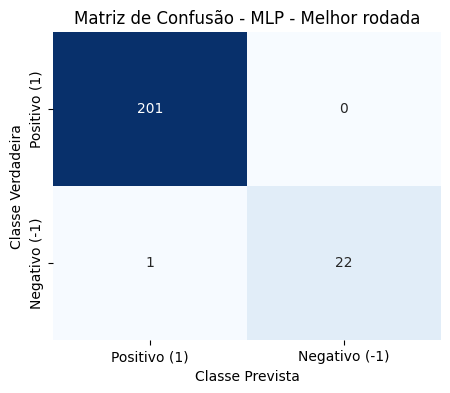

MLP - Pior rodada - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[195   1]
 [  6  22]]

Acurácia: 0.969
Sensibilidade (Recall da classe positiva): 0.995
Especificidade (Recall da classe negativa): 0.786
Precisão: 0.970
F1 Score: 0.982



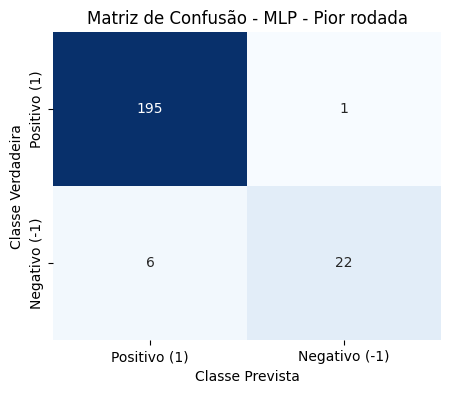

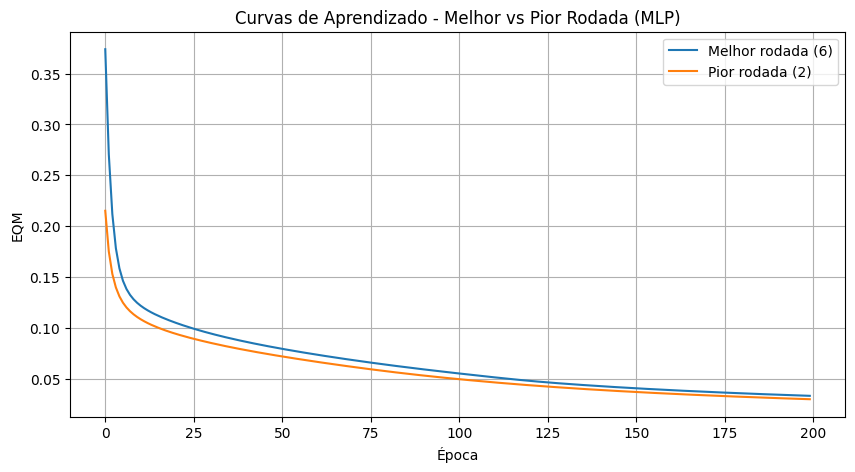

In [ ]:
# --- Cálculo das métricas e seleção das melhores/piores rodadas ---
acc_list, sens_list, spec_list, prec_list, f1_list, cms = [], [], [], [], [], []

for i, (X_train, Y_train, X_test, Y_test, mlp) in enumerate(splits):
    Y_pred = mlp.predict(X_test)
    y_pred = np.sign(Y_pred).flatten()
    y_true = Y_test.flatten()

    # Matriz de confusão manual
    cm = confusion_matrix_manual(y_true, y_pred)

    # Métricas
    acc, sens, spec, prec, f1 = metrics(cm)
    acc_list.append(acc)
    sens_list.append(sens)
    spec_list.append(spec)
    prec_list.append(prec)
    f1_list.append(f1)
    cms.append(cm)

    print(f"Rodada {i+1}: Acc={acc:.3f}, Sens={sens:.3f}, Spec={spec:.3f}, Prec={prec:.3f}, F1={f1:.3f}")

# --- Selecionar melhor e pior rodada pela acurácia ---
idx_best = np.argmax(acc_list)
idx_worst = np.argmin(acc_list)

print("\nMelhor rodada:", idx_best+1, " | Acurácia =", acc_list[idx_best])
print("Pior rodada:  ", idx_worst+1, " | Acurácia =", acc_list[idx_worst])

# --- Exibir matrizes de confusão ---
show_classification_results("MLP - Melhor rodada", cms[idx_best],
                            acc_list[idx_best], sens_list[idx_best], spec_list[idx_best],
                            prec_list[idx_best], f1_list[idx_best])

show_classification_results("MLP - Pior rodada", cms[idx_worst],
                            acc_list[idx_worst], sens_list[idx_worst], spec_list[idx_worst],
                            prec_list[idx_worst], f1_list[idx_worst])

# --- Plotar curva de aprendizado (EQM) ---
plt.figure(figsize=(10,5))
plt.plot(histories[idx_best], label=f"Melhor rodada ({idx_best+1})")
plt.plot(histories[idx_worst], label=f"Pior rodada ({idx_worst+1})")
plt.xlabel("Época")
plt.ylabel("EQM")
plt.title("Curvas de Aprendizado - Melhor vs Pior Rodada (MLP)")
plt.legend()
plt.grid(True)
plt.show()


### Underfitting

In [ ]:
mlp_underfitting = MultilayerPerceptron(X_train=X_train, Y_train=Y_train_mlp, topology=[10], learning_rate=0.000005, max_epoch=500)
mlp_underfitting.fit()

Rede MLP com 41 parâmetros
Tempo: 0.07398s  Época: 1, EQM: 0.404664607723615
Tempo: 0.08204s  Época: 2, EQM: 0.403224528316136
Tempo: 0.07425s  Época: 3, EQM: 0.401827850557641
Tempo: 0.07337s  Época: 4, EQM: 0.400473240007627
Tempo: 0.07199s  Época: 5, EQM: 0.399159375171424
Tempo: 0.07019s  Época: 6, EQM: 0.397884951154367
Tempo: 0.06992s  Época: 7, EQM: 0.396648682836206
Tempo: 0.07181s  Época: 8, EQM: 0.395449307595956
Tempo: 0.07239s  Época: 9, EQM: 0.394285587618811
Tempo: 0.07104s  Época: 10, EQM: 0.393156311817511
Tempo: 0.07139s  Época: 11, EQM: 0.392060297400520
Tempo: 0.07149s  Época: 12, EQM: 0.390996391118906
Tempo: 0.06884s  Época: 13, EQM: 0.389963470222839
Tempo: 0.06956s  Época: 14, EQM: 0.388960443157377
Tempo: 0.06883s  Época: 15, EQM: 0.387986250025693
Tempo: 0.07080s  Época: 16, EQM: 0.387039862846246
Tempo: 0.06919s  Época: 17, EQM: 0.386120285628575
Tempo: 0.07123s  Época: 18, EQM: 0.385226554290675
Tempo: 0.06861s  Época: 19, EQM: 0.384357736438962
Tempo: 0.0737

MLP - Treino - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[639 160]
 [118 203]]

Acurácia: 0.752
Sensibilidade (Recall da classe positiva): 0.800
Especificidade (Recall da classe negativa): 0.632
Precisão: 0.844
F1 Score: 0.821



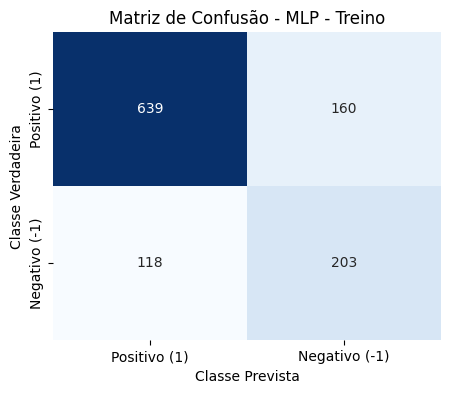

MLP - Teste - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[165  36]
 [ 29  50]]

Acurácia: 0.768
Sensibilidade (Recall da classe positiva): 0.821
Especificidade (Recall da classe negativa): 0.633
Precisão: 0.851
F1 Score: 0.835



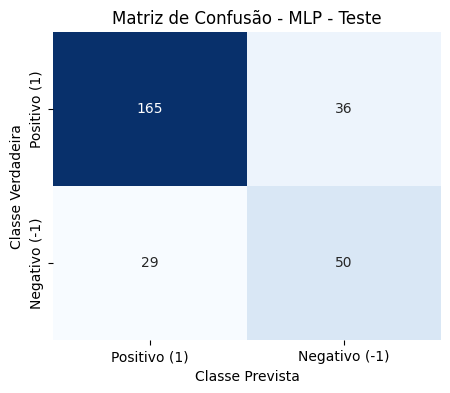

In [ ]:
# Predição
Y_pred_train_raw_underfitting = mlp_underfitting.predict(X_train)
Y_pred_test_raw  = mlp_underfitting.predict(X_test)

# Convertendo saída para {-1,1}
y_pred_train_mlp_underfitting = np.where(Y_pred_train_raw_underfitting[0,:] >= 0, 1, -1)
y_pred_test_mlp_underfitting  = np.where(Y_pred_test_raw[0,:] >= 0, 1, -1)

# Matrizes de confusão
cm_train_mlp_underfitting = confusion_matrix_manual(y_train, y_pred_train_mlp_underfitting)
cm_test_mlp_underfitting  = confusion_matrix_manual(y_test, y_pred_test_mlp_underfitting)

# Métricas
acc_train_mlp_underfitting, sens_train_mlp_underfitting, spec_train_mlp_underfitting, prec_train_mlp_underfitting, f1_train_mlp_underfitting = metrics(cm_train_mlp_underfitting)
acc_test_mlp_underfitting, sens_test_mlp_underfitting, spec_test_mlp_underfitting, prec_test_mlp_underfitting, f1_test_mlp_underfitting = metrics(cm_test_mlp_underfitting)

# Mostrar resultados com heatmap
show_classification_results("MLP - Treino", cm_train_mlp_underfitting, acc_train_mlp_underfitting, sens_train_mlp_underfitting, spec_train_mlp_underfitting, prec_train_mlp_underfitting, f1_train_mlp_underfitting)
show_classification_results("MLP - Teste", cm_test_mlp_underfitting, acc_test_mlp_underfitting, sens_test_mlp_underfitting, spec_test_mlp_underfitting, prec_test_mlp_underfitting, f1_test_mlp_underfitting)

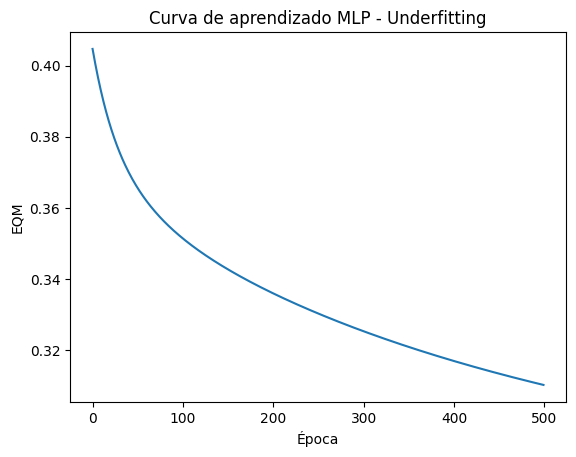

In [ ]:
plt.figure()
plt.plot(mlp_underfitting.history)
plt.xlabel("Época")
plt.ylabel("EQM")
plt.title("Curva de aprendizado MLP - Underfitting")
plt.show()

### Overfitting

In [ ]:
mlp_overfitting = MultilayerPerceptron(X_train=X_train, Y_train=Y_train_mlp, topology=[20, 10], learning_rate=0.00001, max_epoch=800)
mlp_overfitting.fit()

Rede MLP com 281 parâmetros
Tempo: 0.11627s  Época: 1, EQM: 0.640444778557299
Tempo: 0.14296s  Época: 2, EQM: 0.637717453983723
Tempo: 0.19877s  Época: 3, EQM: 0.635004261618246
Tempo: 0.14380s  Época: 4, EQM: 0.632305446827028
Tempo: 0.13881s  Época: 5, EQM: 0.629621246151332
Tempo: 0.13129s  Época: 6, EQM: 0.626951887239449
Tempo: 0.13111s  Época: 7, EQM: 0.624297588793385
Tempo: 0.13013s  Época: 8, EQM: 0.621658560530022
Tempo: 0.13433s  Época: 9, EQM: 0.619035003156571
Tempo: 0.13509s  Época: 10, EQM: 0.616427108359966
Tempo: 0.13251s  Época: 11, EQM: 0.613835058809918
Tempo: 0.12527s  Época: 12, EQM: 0.611259028175235
Tempo: 0.13420s  Época: 13, EQM: 0.608699181153027
Tempo: 0.12417s  Época: 14, EQM: 0.606155673510365
Tempo: 0.13565s  Época: 15, EQM: 0.603628652137949
Tempo: 0.12601s  Época: 16, EQM: 0.601118255115318
Tempo: 0.13168s  Época: 17, EQM: 0.598624611787082
Tempo: 0.12674s  Época: 18, EQM: 0.596147842849702
Tempo: 0.13013s  Época: 19, EQM: 0.593688060448260
Tempo: 0.115

MLP - Treino - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[721  78]
 [154 167]]

Acurácia: 0.793
Sensibilidade (Recall da classe positiva): 0.902
Especificidade (Recall da classe negativa): 0.520
Precisão: 0.824
F1 Score: 0.861



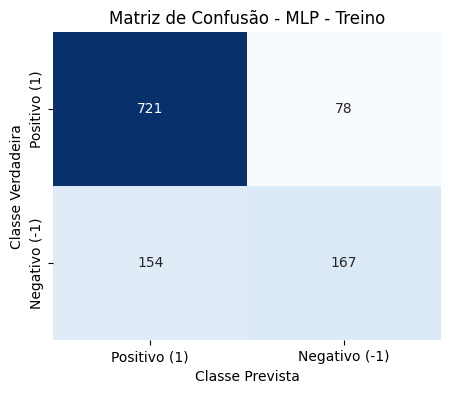

MLP - Teste - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[180  21]
 [ 37  42]]

Acurácia: 0.793
Sensibilidade (Recall da classe positiva): 0.896
Especificidade (Recall da classe negativa): 0.532
Precisão: 0.829
F1 Score: 0.861



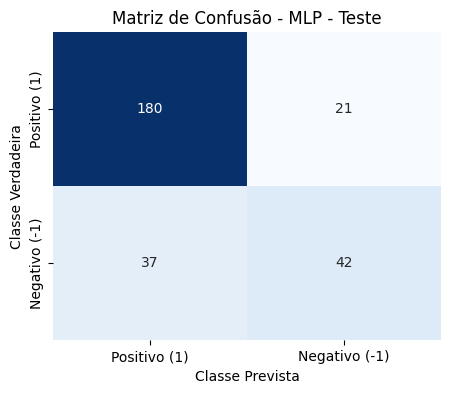

In [ ]:
# Predição
Y_pred_train_raw_overfitting = mlp_overfitting.predict(X_train)
Y_pred_test_raw  = mlp_overfitting.predict(X_test)

# Convertendo saída para {-1,1}
y_pred_train_mlp_overfitting = np.where(Y_pred_train_raw_overfitting[0,:] >= 0, 1, -1)
y_pred_test_mlp_overfitting  = np.where(Y_pred_test_raw[0,:] >= 0, 1, -1)

# Matrizes de confusão
cm_train_mlp_overfitting = confusion_matrix_manual(y_train, y_pred_train_mlp_overfitting)
cm_test_mlp_overfitting  = confusion_matrix_manual(y_test, y_pred_test_mlp_overfitting)

# Métricas
acc_train_mlp_overfitting, sens_train_mlp_overfitting, spec_train_mlp_overfitting, prec_train_mlp_overfitting, f1_train_mlp_overfitting = metrics(cm_train_mlp_overfitting)
acc_test_mlp_overfitting, sens_test_mlp_overfitting, spec_test_mlp_overfitting, prec_test_mlp_overfitting, f1_test_mlp_overfitting = metrics(cm_test_mlp_overfitting)

# Mostrar resultados com heatmap
show_classification_results("MLP - Treino", cm_train_mlp_overfitting, acc_train_mlp_overfitting, sens_train_mlp_overfitting, spec_train_mlp_overfitting, prec_train_mlp_overfitting, f1_train_mlp_overfitting)
show_classification_results("MLP - Teste", cm_test_mlp_overfitting, acc_test_mlp_overfitting, sens_test_mlp_overfitting, spec_test_mlp_overfitting, prec_test_mlp_overfitting, f1_test_mlp_overfitting)

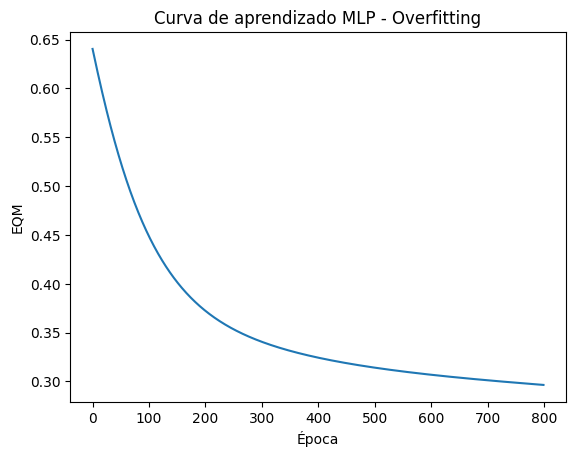

In [ ]:
plt.figure()
plt.plot(mlp_overfitting.history)
plt.xlabel("Época")
plt.ylabel("EQM")
plt.title("Curva de aprendizado MLP - Overfitting")
plt.show()